In [1]:
# Santas travel to deliver packets

# NP-Complete problem: Optimize Santas route/trips to deliver gifts.
# This can be seen also as KNN-problem, but instead of set nr K to include per group, each group is limited by weight. 

# https://traveling-santa.reaktor.com/
# 
# "Santa’s sleigh can only carry 10 metric tons (10,000kg) at a time".
# files include coordinates on Earth, and the weight of presents in grams.
# Your job is to find the most optimal routes to deliver all the presents.
# Santa starts at Korvatunturi, Finland (68.073611N 29.315278E)
# we assume Earth to be a sphere with radius of 6,378km."

In [124]:
import pandas as pd
import time
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial import KDTree
from time import clock
import copy
import random
import csv

In [2]:
# Since over a sphere geometry is different than on flat surface, use haversine.
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in kilometers. 
    return c * r

In [3]:
haversine(-86.67, 36.12, -118.40,33.94 ) 

2889.6158619401444

In [4]:
# test
haversine(29.315278, 68.073611, -86.762233, 40.733034)

6818.460779642609

In [6]:
# weight is in grams. Sleigh can carry 10000 kgs
max_weight = 10000000

In [7]:
# Korvatunturi = 68.073611N 29.315278E  (lat, long)
#home = pd.Series([68.073611, 29.315278])

#long, lat
home = pd.Series([29.315278, 68.073611])
home

0    29.315278
1    68.073611
dtype: float64

In [8]:
colnames = ['id', 'lat', 'long', 'weight']
df = pd.read_csv('nicelist.txt', header=None, delimiter=';', names=colnames)
df.set_index('id', inplace=True)
df['sleigh']=-1
df.head(3)

,lat,long,weight,sleigh
id,,,,
2,40.733034,-86.762233,342917,-1
3,43.029635,-91.094895,974703,-1
4,31.180215,16.596037,215099,-1


In [9]:
# test
haversine(df.iloc[0]['long'], df.iloc[0]['lat'], df.iloc[1]['long'], df.iloc[0]['lat'])

365.4292324325635

In [10]:
# Add distance from Korvatunturi
df['dist_korvatunturi'] = df.apply(lambda row: haversine(29.315278, 68.073611,row['long'], row['lat']), axis=1)
df.head(3)

,lat,long,weight,sleigh,dist_korvatunturi
id,,,,,
2,40.733034,-86.762233,342917,-1,6818.460780
3,43.029635,-91.094895,974703,-1,6716.931863
4,31.180215,16.596037,215099,-1,4189.445884


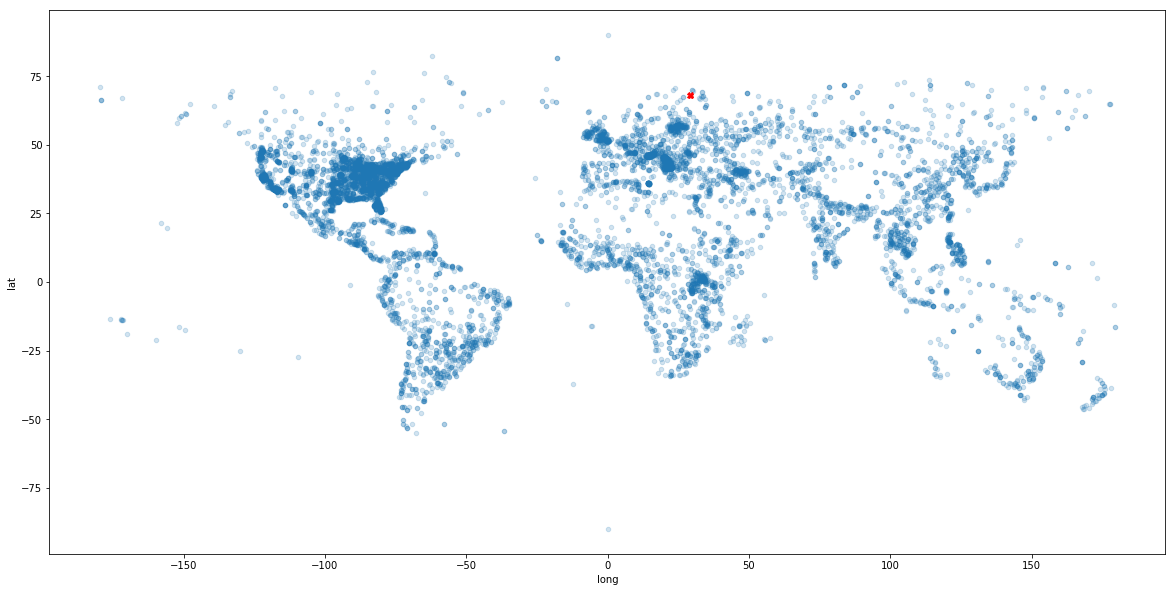

In [11]:
import matplotlib.pyplot as plt
df.plot(kind="scatter", x="long", y="lat", alpha=0.2, figsize=(20,10))
# Red X home / Korvatunturi
plt.plot(home[0], home[1], 'rX', label='point')
plt.show()

In [12]:
# Avg weight
df.describe()

,lat,long,weight,sleigh,dist_korvatunturi
count,10000.000000,10000.000000,1.000000e+04,10000.0,10000.000000
mean,27.720125,-17.268937,5.308228e+05,-1.0,6784.421729
std,24.241659,78.886361,4.291983e+05,0.0,2977.048874
min,-90.000000,-179.593071,5.000000e+00,-1.0,133.077700
25%,14.431097,-85.826239,2.514975e+05,-1.0,5043.700586
50%,36.169634,-40.346728,5.027195e+05,-1.0,6891.140591
75%,42.718775,34.304132,7.563300e+05,-1.0,8099.031980
max,90.000000,179.385081,9.158430e+06,-1.0,17596.295914


In [13]:
# gifts that cant fit 2 per sleigh - only 1 such
df[df['weight']>5000000]

,lat,long,weight,sleigh,dist_korvatunturi
id,,,,,
2298,2.106498,31.400424,9158430,-1,7344.993084


In [14]:
# HIGHER LIMIT 1
# define a higher limit - 136 Million km
# each gift taken with separate sleigh
df['dist_korvatunturi'].sum()*2

135688434.588227

In [16]:
start = time.time()
for i in range(len(df)):
    haversine(df.iloc[0]['long'], df.iloc[0]['lat'], df.iloc[i]['long'], df.iloc[i]['lat'])
end = time.time()
print(end-start)

4.843199014663696


In [17]:
# scipy kdtree
# https://www.programcreek.com/python/example/57350/scipy.spatial.KDTree
# http://code.activestate.com/recipes/578434-a-simple-kd-tree-example-with-custom-euclidean-dis/

In [18]:
# http://library.isr.ist.utl.pt/docs/scipy/spatial.html
x, y = np.mgrid[0:5, 2:8]
tree = KDTree(list(zip(x.ravel(), y.ravel())))
tree.data[0:2]

array([[0, 2],
       [0, 3]])

In [19]:
# https://scipy-cookbook.readthedocs.io/items/KDTree_example.html
#!python numbers=disable

# Copyleft 2008 Sturla Molden
# University of Oslo

#import psyco
#psyco.full()

import numpy

def kdtree( data, leafsize=10 ):
    """
    build a kd-tree for O(n log n) nearest neighbour search

    input:
        data:       2D ndarray, shape =(ndim,ndata), preferentially C order
        leafsize:   max. number of data points to leave in a leaf

    output:
        kd-tree:    list of tuples
    """

    ndim = data.shape[0]
    ndata = data.shape[1]

    # find bounding hyper-rectangle
    hrect = numpy.zeros((2,data.shape[0]))
    hrect[0,:] = data.min(axis=1)
    hrect[1,:] = data.max(axis=1)

    # create root of kd-tree
    idx = numpy.argsort(data[0,:], kind='mergesort')
    data[:,:] = data[:,idx]
    splitval = data[0,ndata//2]

    left_hrect = hrect.copy()
    right_hrect = hrect.copy()
    left_hrect[1, 0] = splitval
    right_hrect[0, 0] = splitval

    tree = [(None, None, left_hrect, right_hrect, None, None)]

    stack = [(data[:,:ndata//2], idx[:ndata//2], 1, 0, True),
             (data[:,ndata//2:], idx[ndata//2:], 1, 0, False)]

    # recursively split data in halves using hyper-rectangles:
    while stack:

        # pop data off stack
        data, didx, depth, parent, leftbranch = stack.pop()
        ndata = data.shape[1]
        nodeptr = len(tree)

        # update parent node

        _didx, _data, _left_hrect, _right_hrect, left, right = tree[parent]

        tree[parent] = (_didx, _data, _left_hrect, _right_hrect, nodeptr, right) if leftbranch \
            else (_didx, _data, _left_hrect, _right_hrect, left, nodeptr)

        # insert node in kd-tree

        # leaf node?
        if ndata <= leafsize:
            _didx = didx.copy()
            _data = data.copy()
            leaf = (_didx, _data, None, None, 0, 0)
            tree.append(leaf)

        # not a leaf, split the data in two      
        else:
            splitdim = depth % ndim
            idx = numpy.argsort(data[splitdim,:], kind='mergesort')
            data[:,:] = data[:,idx]
            didx = didx[idx]
            nodeptr = len(tree)
            stack.append((data[:,:ndata//2], didx[:ndata//2], depth+1, nodeptr, True))
            stack.append((data[:,ndata//2:], didx[ndata//2:], depth+1, nodeptr, False))
            splitval = data[splitdim,ndata//2]
            if leftbranch:
                left_hrect = _left_hrect.copy()
                right_hrect = _left_hrect.copy()
            else:
                left_hrect = _right_hrect.copy()
                right_hrect = _right_hrect.copy()
            left_hrect[1, splitdim] = splitval
            right_hrect[0, splitdim] = splitval
            # append node to tree
            tree.append((None, None, left_hrect, right_hrect, None, None))

    return tree

In [21]:
#!python numbers=disable

def intersect(hrect, r2, centroid):
    """
    checks if the hyperrectangle hrect intersects with the
    hypersphere defined by centroid and r2
    """
    maxval = hrect[1,:]
    minval = hrect[0,:]
    p = centroid.copy()
    idx = p < minval
    p[idx] = minval[idx]
    idx = p > maxval
    p[idx] = maxval[idx]
    return ((p-centroid)**2).sum() < r2


def quadratic_knn_search(data, lidx, ldata, K):
    """ find K nearest neighbours of data among ldata """
    ndata = ldata.shape[1]
    param = ldata.shape[0]
    K = K if K < ndata else ndata
    retval = []
    sqd = ((ldata - data[:,:ndata])**2).sum(axis=0) # data.reshape((param,1)).repeat(ndata, axis=1);
    idx = numpy.argsort(sqd, kind='mergesort')
    idx = idx[:K]
    return list(zip(sqd[idx], lidx[idx]))


def search_kdtree(tree, datapoint, K):
    """ find the k nearest neighbours of datapoint in a kdtree """
    stack = [tree[0]]
    knn = [(numpy.inf, None)]*K
    _datapt = datapoint[:,0]
    while stack:

        leaf_idx, leaf_data, left_hrect, \
                  right_hrect, left, right = stack.pop()

        # leaf
        if leaf_idx is not None:
            _knn = quadratic_knn_search(datapoint, leaf_idx, leaf_data, K)
            if _knn[0][0] < knn[-1][0]:
                knn = sorted(knn + _knn)[:K]

        # not a leaf
        else:

            # check left branch
            if intersect(left_hrect, knn[-1][0], _datapt):
                stack.append(tree[left])

            # chech right branch
            if intersect(right_hrect, knn[-1][0], _datapt):
                stack.append(tree[right])
    return knn


def knn_search( data, K, leafsize=2048 ):

    """ find the K nearest neighbours for data points in data,
        using an O(n log n) kd-tree """

    ndata = data.shape[1]
    param = data.shape[0]

    # build kdtree
    tree = kdtree(data.copy(), leafsize=leafsize)

    # search kdtree
    knn = []
    for i in numpy.arange(ndata):
        _data = data[:,i].reshape((param,1)).repeat(leafsize, axis=1);
        _knn = search_kdtree(tree, _data, K+1)
        knn.append(_knn[1:])

    return knn


def radius_search(tree, datapoint, radius):
    """ find all points within radius of datapoint """
    stack = [tree[0]]
    inside = []
    while stack:

        leaf_idx, leaf_data, left_hrect, \
                  right_hrect, left, right = stack.pop()

        # leaf
        if leaf_idx is not None:
            param=leaf_data.shape[0]
            distance = numpy.sqrt(((leaf_data - datapoint.reshape((param,1)))**2).sum(axis=0))
            near = numpy.where(distance<=radius)
            if len(near[0]):
                idx = leaf_idx[near]
                distance = distance[near]
                inside += (zip(distance, idx))

        else:

            if intersect(left_hrect, radius, datapoint):
                stack.append(tree[left])

            if intersect(right_hrect, radius, datapoint):
                stack.append(tree[right])

    return inside

In [22]:
#!python numbers=disable

try:
    import multiprocessing as processing
except:
    import processing

import ctypes, os

def __num_processors():
    if os.name == 'nt': # Windows
        return int(os.getenv('NUMBER_OF_PROCESSORS'))
    else: # glibc (Linux, *BSD, Apple)
        get_nprocs = ctypes.cdll.libc.get_nprocs
        get_nprocs.restype = ctypes.c_int
        get_nprocs.argtypes = []
        return get_nprocs()

def __search_kdtree(tree, data, K, leafsize):
    knn = []
    param = data.shape[0]
    ndata = data.shape[1]
    for i in numpy.arange(ndata):
        _data = data[:,i].reshape((param,1)).repeat(leafsize, axis=1);
        _knn = search_kdtree(tree, _data, K+1)
        knn.append(_knn[1:])
    return knn

def __remote_process(rank, qin, qout, tree, K, leafsize):
    while 1:
        # read input queue (block until data arrives)
        nc, data = qin.get()
        # process data
        knn = __search_kdtree(tree, data, K, leafsize)
        # write to output queue
        qout.put((nc,knn))

def knn_search_parallel(data, K, leafsize=2048):

    """ find the K nearest neighbours for data points in data,
        using an O(n log n) kd-tree, exploiting all logical
        processors on the computer """

    ndata = data.shape[1]
    param = data.shape[0]
    nproc = __num_processors()
    # build kdtree
    tree = kdtree(data.copy(), leafsize=leafsize)
    # compute chunk size
    chunk_size = data.shape[1] / (4*nproc)
    chunk_size = 100 if chunk_size < 100 else chunk_size
    # set up a pool of processes
    qin = processing.Queue(maxsize=ndata/chunk_size)
    qout = processing.Queue(maxsize=ndata/chunk_size)
    pool = [processing.Process(target=__remote_process,
                args=(rank, qin, qout, tree, K, leafsize))
                    for rank in range(nproc)]
    for p in pool: p.start()
    # put data chunks in input queue
    cur, nc = 0, 0
    while 1:
        _data = data[:,cur:cur+chunk_size]
        if _data.shape[1] == 0: break
        qin.put((nc,_data))
        cur += chunk_size
        nc += 1
    # read output queue
    knn = []
    while len(knn) < nc:
        knn += [qout.get()]
    # avoid race condition
    _knn = [n for i,n in sorted(knn)]
    knn = []
    for tmp in _knn:
        knn += tmp
    # terminate workers
    for p in pool: p.terminate()
    return knn

In [23]:
#!python numbers=disable
from time import clock

def test():
    K = 11
    ndata = 10000
    ndim = 12
    data =  10 * numpy.random.rand(ndata*ndim).reshape((ndim,ndata) )
    knn = knn_search(data, K)

if __name__ == '__main__':
    t0 = clock()
    test()
    t1 = clock()
    print("Elapsed time %.2f seconds") ; print(t1-t0)

    #import profile          # using Python's profiler is not useful if you are
    #profile.run('test()')   # running the parallel search.

Elapsed time %.2f seconds
12.372141


In [24]:
### Test example
K = 11
ndata = 100
ndim = 2
data =  10 * numpy.random.rand(ndata*ndim).reshape((ndim,ndata) )
    
t0 = clock()
print("Elapsed time %.2f seconds") ; print(t1-t0)
t1 = clock()
knn = knn_search(data, K)

Elapsed time %.2f seconds
-0.00490999999999886


In [25]:
len(knn)

100

In [26]:
# libc error for parallel version
# knn = knn_search_parallel(data, K)

In [27]:
### Test with real data
treedata = df[['long', 'lat']]
treedat = np.asarray(treedata)
print(treedat.shape)

#ndata = 10000
ndata = len(treedat)
ndim = 2

data = treedat.reshape(ndim,ndata)
print(data.shape)

K = 10
#data =  10 * numpy.random.rand(ndata*ndim).reshape((ndim,ndata) )
t0 = clock()
knn = knn_search(data, K)
t1 = clock()
print(t1-t0)

(10000, 2)
(2, 10000)
5.391992999999999


In [28]:
knn[0]

[(0.035337873581000136, 8964),
 (0.9283121356569914, 5852),
 (1.266208588250013, 9578),
 (1.4500857272850018, 9328),
 (1.5663806009299814, 8870),
 (1.5857399166370032, 5124),
 (2.221291289120009, 9302),
 (2.4370281524809574, 882),
 (2.8134255199210036, 100),
 (3.3382238789840173, 6154)]

### Main run

In [29]:
# each gifts initialized free, ie no sleigh
df['sleigh']= -1
# Np array of free sleighs coordinates
free= df[df['sleigh']==-1]
freeones = free[['long','lat', 'weight']]
print(freeones[0:3])

# Input required is np.arary with only coordinates, no id field
np_freeones = np.asarray(freeones[['long','lat']])
print('------')
print(np_freeones[0:3])

         long        lat  weight
id                              
2  -86.762233  40.733034  342917
3  -91.094895  43.029635  974703
4   16.596037  31.180215  215099
------
[[-86.762233  40.733034]
 [-91.094895  43.029635]
 [ 16.596037  31.180215]]


In [30]:
np_df= np.asarray(df[['long','lat']])
np_df[0]

array([-86.762233,  40.733034])

In [31]:
df[0:3]

,lat,long,weight,sleigh,dist_korvatunturi
id,,,,,
2,40.733034,-86.762233,342917,-1,6818.460780
3,43.029635,-91.094895,974703,-1,6716.931863
4,31.180215,16.596037,215099,-1,4189.445884


In [32]:
# Test - individual datapoint
# Gift #2
this = df.loc[2][['long','lat']]
print(this)
datapoint = np.asarray(this)
datapoint = datapoint.reshape(2,1) # give it dim 1 instead of , and rotate
print('----')
print(datapoint)

long   -86.762233
lat     40.733034
Name: 2, dtype: float64
----
[[-86.762233]
 [ 40.733034]]


In [30]:
# def search_kdtree(tree, datapoint, K):
datapoint

array([[-86.762233],
       [ 40.733034]])

In [31]:
np_freeones

array([[-86.762233,  40.733034],
       [-91.094895,  43.029635],
       [ 16.596037,  31.180215],
       ...,
       [-84.314389,  33.463295],
       [134.530749,  34.091971],
       [-63.770996, -22.55115 ]])

In [32]:
# Test
K = 10

data = np_freeones
# switch axels
ndata = len(np_freeones)
ndim = 2
data = data.reshape(ndim,ndata)

t0 = clock()
knn = knn_search(data, K)
t1 = clock()
print(t1-t0)

5.421358999999999


In [33]:
len(knn)

10000

In [34]:
#treedata

In [35]:
type(treedata)

pandas.core.frame.DataFrame

In [36]:
# individual point search requires Tree as input
#tree = kdtree( treedata, leafsize=10 )
tree = kdtree(data, leafsize=10 )
# tree = kdtree(np_freeones, leafsize=10 )

In [37]:
K = 10
ndata = len(np_freeones)
ndim = 2
#data =  10 * numpy.random.rand(ndata*ndim).reshape((ndim,ndata) )
#data = treedata.reshape(ndim,ndata)
#datap = datapoint.reshape(2,1)

near = search_kdtree(tree, datapoint, K)
#near = search_kdtree(tree, datap, K)

In [38]:
near

[(1.0729000158739854, 5296),
 (3.045992294809971, 4380),
 (4.25588072516002, 7400),
 (4.8058428571289635, 1540),
 (6.378489357385014, 96),
 (8.241262304122005, 3314),
 (8.892256276754043, 8656),
 (9.439722041268977, 9298),
 (10.886933755316026, 4246),
 (11.173561781508077, 3756)]

In [33]:
def distance(point1, point2):
    '''
    input: 2 numpy arrays with single point: longitude, latitude 
    '''
    #confirm only 2 columns
    assert len(point1)==2 or len(point1)==3
    assert len(point2)==2 or len(point2)==3
    
    return haversine(point1[0], point1[1], point2[0], point2[1])
#test
distance(np_df[0], np_df[1])

440.6969447506693

In [34]:
def distance_panda(point1, point2):
    '''Input DataFrame, allowed to have extra fields'''
    #haversine(df.iloc[0]['long'], df.iloc[0]['lat'], df.iloc[i]['long'], df.iloc[i]['lat'])
    return haversine(point1['long'], point1['lat'], point2['long'], point2['lat'])
#test
distance_panda(this, freeones.loc[3])

440.6969447506693

In [42]:
freeones.loc[5341]

long          54.012250
lat           57.027138
weight    831256.000000
Name: 5341, dtype: float64

In [43]:
datapoint

array([[-86.762233],
       [ 40.733034]])

In [44]:
distance(datapoint, np_df[5340])

2120.8743472471565

In [45]:
# Each points distance to this one
# distances = freeones.apply(lambda row: distance(this, row), axis=1)
#this = np_df[0]
distances = np.array( [distance(this, row) for row in np_df] )

In [46]:
distances[0:4]

array([   0.        ,  440.69694475, 8811.92943327, 8352.661111  ])

In [ ]:
print(distances.min())
print(distances.idxmin())

In [ ]:
i= 5340
haversine(df.iloc[0]['long'], df.iloc[0]['lat'], df.loc[i]['long'], df.loc[i]['lat'])

In [ ]:
distance_panda(freeones.iloc[0], freeones.loc[i])

In [ ]:
distance_panda(freeones.iloc[0], freeones.iloc[1])

In [ ]:
df.head()

In [60]:
# LIST OF SLEIGHS/TAXIS 
taxis = []
taxis.append([2,3])
taxis[0]
#taxi_dist(taxis[0])

[2, 3]

In [36]:
def taxi_dist(taxi):
    '''Return distance through home, points in list, home
       input: integer list of locations'''
    route=[]
    route.append(home)
    for i in taxi:
        #route.append(  np_df[ df.index.get_loc(i)]  )
        route.append( np.asarray(df.loc[i][['long','lat']]) )
    route.append(home)    

    sum=0
    for i in range(len(route)-1):
            sum+=distance(route[i], route[i+1]) 
    return sum
#test
#taxi_dist(taxis2[0])

In [108]:
def group_dist(taxi, start=False, end=False):
    '''Return distance between points, not adding home location
       input: integer list of locations
       params: start: add home as start location to list
               end:   add home as end location to list
       '''
    route=[]
    
    if start==True:
        route.append(home)
    for i in taxi:
        route.append( np.asarray(df.loc[i][['long','lat']]) )
        
    if end==True:
        route.append(home)
        
    sum=0
    for i in range(len(route)-1):
            sum+=distance(route[i], route[i+1]) 
    return sum
test
group_dist([2,3,4])

9413.416736776197

In [109]:
group_dist([2,3,4], start=True)

16231.877516418805

In [110]:
group_dist([2,3,4], start=True, end=True)

20421.32340085681

In [ ]:
def taxi_weight(taxi):
    '''Return total weight of gifts in route
       input: integer list of locations'''
    route=[]
    for i in taxi:
        #route.append(df.iloc[  df.index.get_loc(i)  ])
        route.append(df.loc[i])
        
    #print(route)

    sum=0
    for i in range(len(route)):
            sum+=route[i]['weight']
    return sum
#test
taxi_weight(taxis[0])

In [ ]:
def taxi_info(taxi):
    '''Print info about route
       input: integer list of locations'''
    print(df.loc[taxi])
    #print(np_df[taxi])
#test
taxi_info(taxis[0])

In [65]:
# if item #2, get indes of its row
# iloc for loc
df.index.get_loc(2)

0

In [68]:
np_df[df.index.get_loc(2)]

array([-86.762233,  40.733034])

In [39]:
def taxi_build_route(startpoint, knn):
    '''Pick always item furthest from home
   find 30 knn
   by order of distance to 1st, if fits under 10 tons, add next
   score: 12.8M (12837118)   '''
    
    route=[]
    route.append(startpoint)
    weight_total = taxi_weight(route)
    #print(weight_total)
    
    for i in knn:
        #print(f'Taxi_build_route i in knn: {i}')
        weight_total = taxi_weight(route)
        weight_next = df.loc[i]['weight']
        if weight_total + weight_next <= max_weight:
            route.append(i)
    return route
#test
#taxi_build_route()

In [40]:
def taxi_build_route2(startpoint, knn):
    '''Input startpoint: int of first item to add 
       knn list of n nearest points to startpoint
    
       On version 1 we added always knn in order, as logn as they fit under max weight
       At times though, distance to next item x can be larger than distance to home and back to x with empty
       load!
       
       Also if our load is 9 tons out of 10 tons and current->home-> x is just little longer than direct to x,
       we might wanna go home and arrive to x with empty load.
       
       So we want to add a function comparing 
       - current load percentage, 
       - distance to home and 
       - distance to next item
       
       The further we are from home, the longer way we are willing to travel sideways
       Consider also
       - distance to home vs
       - distance to home via x
       This will tell how much extra way x would bring.
       In good case x can be far from current, but very close to direct line between current and home!
       
       Also notice that each item has a hardness-number
       If we have options to pick 500kg item at 10.000 km from home at extra route y or 
       500kg item at 100 km from home at extra route 0.1y, the one further might be lot better, 
       since coming later to this far is expensive, while item B is cheap to come at later route.
    
    '''
    route=[]
    route.append(startpoint)
    weight_total = taxi_weight(route)
    #print(weight_total)
    
    for i in knn:
        #print(i)
        weight_total = taxi_weight(route)
        weight_next = df.loc[i]['weight']
        # fits y weigh
        if weight_total + weight_next <= max_weight:
                   
            eps = 1e-7   
            #multiplier for go home, then to dest i
            dist_direct = distance_panda(df.loc[startpoint], df.loc[i])
            
            dist_through_home = distance( np_df[ df.index.get_loc(startpoint)] , home) + distance(home, np_df[ df.index.get_loc(i)])
            multiplyer_dist = dist_through_home / (dist_direct+eps)
            
            #multiplayer space
            weight_direct = weight_total + weight_next
            weight_through_home = weight_next
            multiplyer_weight = (max_weight - weight_through_home) / (max_weight - weight_direct)
            
            #hypothesis, saving?
            # example, cargo 0.5 full, next is 0.1, direct would bring 0.6 full
            # distance through home is 1.2x multiplier, space for cargo through home
            # would be free space: 0.9 / 0.4 = 2.25 x
            # hypothesis, by going home to empty, on average we save
            
            #if multiplyer_weight > multiplyer_dist:
            
            # don't go home, go directly to next
            if not(multiplyer_weight > multiplyer_dist):
                route.append(i)
                
            #weight_free = max_weight - weight_total
            #weight_free_percentage = weight_total / max_weight            
            #HARDNESS NUMBER FOR EACH ITEM
            # weight * distance?
        
            #extra_distance 
            #(taxi_dist(startpoint, df.iloc[i]) + taxi_dist(df.iloc[i], home) / taxi_dist(startpoint, home))
            
           # fits by distance and loc  
           # relation of dist to new x + dist to home vs directly home
            #weight_free = (weight_total / max_weight)
            #if (taxi_dist(startpoint, df.iloc[i]) + taxi_dist(df.iloc[i], home) / taxi_dist(startpoint, home))                
    return route

In [ ]:
def taxi_build_route3(startpoint, knn):
    '''Within knn, add nearest in chain
       Input startpoint: int of first item to add 
       knn list of n nearest points to startpoint
    
       On version 1 we added always knn in order, as logn as they fit under max weight
       At times though, distance to next item x can be larger than distance to home and back to x with empty
       load!
       
       Also if our load is 9 tons out of 10 tons and current->home-> x is just little longer than direct to x,
       we might wanna go home and arrive to x with empty load.
       
       So we want to add a function comparing 
       - current load percentage, 
       - distance to home and 
       - distance to next item
       
       The further we are from home, the longer way we are willing to travel sideways
       Consider also
       - distance to home vs
       - distance to home via x
       This will tell how much extra way x would bring.
       In good case x can be far from current, but very close to direct line between current and home!
       
       Also notice that each item has a hardness-number
       If we have options to pick 500kg item at 10.000 km from home at extra route y or 
       500kg item at 100 km from home at extra route 0.1y, the one further might be lot better, 
       since coming later to this far is expensive, while item B is cheap to come at later route.
    
    '''
    route=[]
    route.append(startpoint)
    weight_total = taxi_weight(route)
    #print(weight_total)
    
    for i in knn:
        #print(i)
        weight_total = taxi_weight(route)
        weight_next = df.loc[i]['weight']
        # fits y weigh
        if weight_total + weight_next <= max_weight:
                   
            eps = 1e-7   
            #multiplier for go home, then to dest i
            dist_direct = distance_panda(df.loc[startpoint], df.loc[i])
            
            dist_through_home = distance( np_df[ df.index.get_loc(startpoint)] , home) + distance(home, np_df[ df.index.get_loc(i)])
            multiplyer_dist = dist_through_home / (dist_direct+eps)
            
            #multiplyer space
            weight_direct = weight_total + weight_next
            weight_through_home = weight_next
            multiplyer_weight = (max_weight - weight_through_home) / (max_weight - weight_direct)
            
            #hypothesis, saving?
            # example, cargo 0.5 full, next is 0.1, direct would bring 0.6 full
            # distance through home is 1.2x multiplier, space for cargo through home
            # would be free space: 0.9 / 0.4 = 2.25 x
            # hypothesis, by going home to empty, on average we save
            
            #if multiplyer_weight > multiplyer_dist:
            
            # don't go home, go directly to next
            if not(multiplyer_weight > multiplyer_dist):
                route.append(i)
                
            #weight_free = max_weight - weight_total
            #weight_free_percentage = weight_total / max_weight            
            #HARDNESS NUMBER FOR EACH ITEM
            # weight * distance?
        
            #extra_distance 
            #(taxi_dist(startpoint, df.iloc[i]) + taxi_dist(df.iloc[i], home) / taxi_dist(startpoint, home))
            
           # fits by distance and loc  
           # relation of dist to new x + dist to home vs directly home
            #weight_free = (weight_total / max_weight)
            #if (taxi_dist(startpoint, df.iloc[i]) + taxi_dist(df.iloc[i], home) / taxi_dist(startpoint, home))                
    return route

In [41]:
def mark_taken(df, locations):
    '''mark locations on list as taken
       '''
    df['sleigh'].loc[locations]=10000

In [42]:
sleighs=[]

i =df['dist_korvatunturi'].idxmax()
print(i)
this = df.iloc[i]
# Each points distance to this one
distances = freeones.apply(lambda row: distance_panda(this, row), axis=1)
knn = distances.nsmallest(30)

print(knn[0:4])

# while  sleight weight under 10k kg
# add next closest to same sleigh

8826
id
8828      0.000000
8660      4.560893
6249    151.962850
4441    153.381073
dtype: float64


In [56]:
knn.index[1:]

Int64Index([8660, 6249, 4441, 8259, 8526, 3033, 7597, 8224, 2652, 5369, 8121,
            3952, 2292, 4610, 2516, 6006, 8852, 4869, 5049, 7879, 5691, 8670,
            6171, 9764,  946, 1351, 7605,  820, 7802],
           dtype='int64', name='id')

In [76]:
newtaxi = taxi_build_route(i, knn.index[1:])
print(len(newtaxi))

18


### Repeat


In [323]:
# Get free ones
free= df[df['sleigh']==-1]
freeones = free[['id','long','lat', 'weight']]

# Input required is np.arary with only coordinates, no id field
np_freeones = np.asarray(freeones[['long','lat']])
print('Free remaining'); print(len(freeones))
print('------')
print(np_freeones[0:3])

Free remaining
9912
------
[[ 43.029635 -91.094895]
 [ 31.180215  16.596037]
 [-28.657398 -55.964951]]


In [324]:
#Pick NEXT gift (furthest from home) to pick up and its knn

i =free['dist_korvatunturi'].idxmax()
print(i)
this = df.iloc[i]
# Each points distance to this one
distances = freeones.apply(lambda row: distance(this, row), axis=1)
knn = distances.nsmallest(30)

print(knn[0:4])

9278
9278      0.000000
8557    297.985948
278     454.053433
3522    484.076805
dtype: float64


In [325]:
# Plan a route
newtaxi = taxi_build_route(i, knn.index[1:])
print(len(newtaxi))

#Add to routes
taxis.append(newtaxi)

#Mark those taken
mark_taken(df, newtaxi)

678340.0
21


/home/mark/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [331]:
# Total distance of all taxis
total_dist = np.sum([taxi_dist(item) for item in taxis])
print(total_dist)

478771.4884847733

In [354]:
len(df)

200

### In one loop

In [358]:
df_full = df
#df = df[0:500]
df = df_full
len(df)

10000

In [ ]:
'''Pick always item furthest from home
   find knn
   by order of distance to 1st, if fits under 10 tons, add next
                           '''
#Reset all to free
df['sleigh']=-1
taxis=[]

# Get free ones
free= df[df['sleigh']==-1]

while len(free) >0:
    freeones = free[['long','lat', 'weight']]

    # Input required is np.arary with only coordinates
    np_freeones = np.asarray(freeones[['long','lat']])
    print('Free remaining'); print(len(freeones))

#Pick NEXT gift (furthest from home) to pick up and its knn
    
    #i = free.loc[free['dist_korvatunturi'].idxmax()]
    i = free['dist_korvatunturi'].idxmax()
    #print(f'Most distant i from home {i}')
    thispoint = np.asarray(free.loc[ i ][['long','lat']])

    # Each points distance to this one    
    distances =  [distance(thispoint, row) for row in np_freeones] 
    distances = pd.Series(distances)
    
    # these are indexes in numpy list, not yet id:s of items
    # for example 2nd row in results is index 1, though smallest item# is 2
    knn = distances.nsmallest(40)
    
    # get ids for them
    # freeones[0] has index/name of 5
    knn_indices = [ freeones.index[index] for index in knn.index]
    
    
# Plan a route
    #newtaxi = taxi_build_route(i, knn.index[1:])
    newtaxi = taxi_build_route(i, knn_indices[1:])

    #Add to routes
    taxis.append(newtaxi)

    #Mark those taken
    mark_taken(df, newtaxi)
    # Update free ones
    free= df[df['sleigh']==-1]
    
# Total distance of all taxis
print('Total distance of all routes')
total_dist = np.sum([taxi_dist(item) for item in taxis])
print(total_dist)

In [238]:
print('Total distance of all routes')
total_dist = np.sum([taxi_dist(item) for item in taxis])
print(total_dist)

Total distance of all routes
8713230.292004172


### Save result

In [226]:
import csv
with open("solution_route1_change2_optimize_7_98M.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerows(taxis2)

In [125]:
with open("solution_nperm3_no_start_end.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerows(taxis2)
    
# Real scored: Well done! Your result was    8016097784 meters.
# own counted Total distance of all routes: 10191414.869035328

# nperm3, no_start_end Well done! Your result was 7961271115 meters.

In [190]:
with open("solution_route1_greedyb.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerows(taxis2)
    
# Well done! Your result was 8020739245 meters.
# own counted Total distance of all routes: 10884966.111994263

### Statistics

In [214]:
# nr of taxis
print(f'Nr of taxis: {len(taxis)}')

# Avg items per taxi
print(f'Avg items per taxi: {np.mean([len(item) for item in taxis])}')

# Avg weight per taxi
print(f'Avg weight of taxi: {np.mean([taxi_weight(item) for item in taxis])}')

# Avg length of taxi ride
print(f'Avg length of taxi route: {np.mean([taxi_dist(item) for item in taxis])}')


Nr of taxis: 535
Avg items per taxi: 18.69158878504673
Avg weight of taxi: 9921920.575700935
Avg length of taxi route: 16241.542148096532


In [ ]:
# route1, fixed coord 8.68M
# Nr of taxis: 535
# Avg items per taxi: 18.69158878504673
# Avg weight of taxi: 9921920.575700935
# Avg length of taxi route: 16241.542148096532

In [ ]:
# route1, knn=40
# 8690193.153362121



In [ ]:
# route1 fixed indexing 10,8M
# Nr of taxis: 535
# Avg items per taxi: 18.69158878504673
# Avg weight of taxi: 9921920.575700935
# Avg length of taxi route: 20345.731050456565

# route2 fixed indexing, 11M
# Nr of taxis: 562
# Avg items per taxi: 17.793594306049823
# Avg weight of taxi: 9445244.676156584
# Avg length of taxi route: 19719.974044225128


# route1 12M
# Nr of taxis: 536
# Avg items per taxi 18.65671641791045
# Avg weight of taxi 9903409.529850746
# Avg length of taxi route 23949.846369940846

# route2 16,9M
#Nr of taxis: 757
#Avg items per taxi 13.21003963011889
#Avg weight of taxi 7012189.574636724
#Avg length of taxi route 22411.432553687224

# route2 fixed long,lat in np,  65M - large
Nr of taxis:  1559
Avg items per taxi 6.428479794740218
Avg weight of taxi 3412421.434252726
Avg length of taxi route 42015.77227992759
# WHY avg length almost double to those with more items?


In [168]:
# how much distance per kg on average?

wei = np.sum([taxi_weight(item) for item in taxis])
dis = np.sum([taxi_dist(item) for item in taxis])
print(wei/dis)

487.66596545953473


In [169]:
print(dis/(wei/1000))
# is this 2,4 km per kg?


2.050583946447207


### Visualize a route

In [182]:
df.loc[8826]

lat                    -90.000000
long                     0.000000
weight                8520.000000
sleigh               10000.000000
dist_korvatunturi    17596.295914
Name: 8826, dtype: float64

In [196]:
taxis[0]

[8826,
 5049,
 3260,
 9403,
 8224,
 7597,
 3033,
 8526,
 4441,
 5418,
 3899,
 6249,
 8259,
 8828,
 8660,
 2516]

In [175]:
distance_panda(df.loc[8826], df.loc[5049])

3904.2857505922034

In [176]:
distance_panda(df.loc[8826], df.loc[3260])

3972.0615006910975

In [223]:
distance_panda(df.loc[5049], df.loc[3260])

1990.9262580912575

In [224]:
distance_panda(df.loc[8826], df.loc[9403])

3972.6031696981995

In [164]:
routex = df[['long','lat']].loc[taxis[0]]
routex

,long,lat
id,,
8826,0.000000,-90.000000
5049,-67.637410,-54.926451
3260,-36.506344,-54.317598
9403,-36.513174,-54.312732
8224,-70.928661,-53.163496
7597,-70.972913,-53.148835
3033,-70.941173,-53.128911
8526,-71.454606,-52.624282
4441,-72.497241,-51.719119


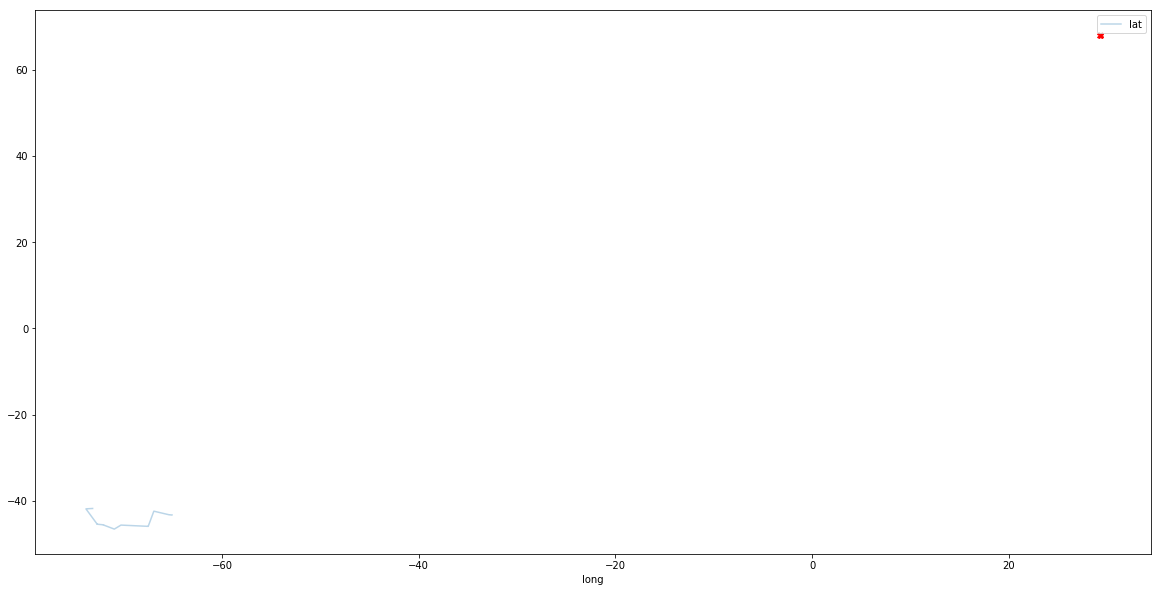

In [217]:
# Plot route
# this is south tip of South america

routex.plot(kind="line", x="long", y="lat", alpha=0.3, figsize=(20,10))
# Red X home / Korvatunturi
plt.plot(home[0], home[1], 'rX', label='point')
plt.show()

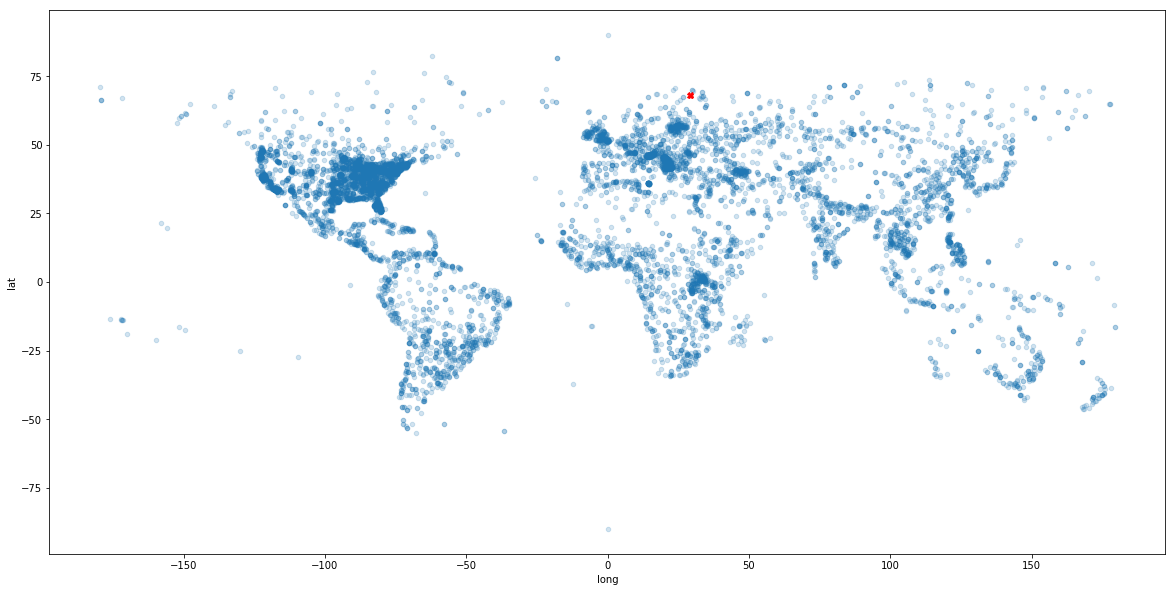

In [216]:
df.plot(kind="scatter", x="long", y="lat", alpha=0.2, figsize=(20,10))
# Red X home / Korvatunturi
plt.plot(home[0], home[1], 'rX', label='point')
plt.show()

### Optimize single taxis

In [159]:
print('Total distance of all routes')
total_dist = np.sum([taxi_dist(item) for item in taxis])
print(total_dist)


Total distance of all routes
10884966.111994263


In [160]:
taxi_dist(taxis[0])

46654.228833948626

In [ ]:
import copy
import random
route = copy.deepcopy(item)

In [97]:
print(route)
random.shuffle(route)
print(route)

[8826, 5049, 3260, 9403, 8224, 7597, 3033, 8526, 4441, 5418, 3899, 6249, 8259, 8828, 8660, 2516, 2652, 5369, 3742, 7259]
[8660, 6249, 4441, 7597, 2652, 3899, 8259, 7259, 9403, 5049, 8828, 2516, 3033, 3742, 8826, 5369, 5418, 8526, 3260, 8224]


In [ ]:
# Random permutation, improves around 5%
#
# original 46654
# New highscore: 43852

highscore = taxi_dist(item)
print(highscore)

saveroute=[]

for i in range(1000000):
    random.shuffle(route)
    newscore = taxi_dist(route)
    #print(newscore)
    if i % 10000 ==0:
        print(i)
    if newscore < highscore:
        saveroute = route
        highscore = newscore
        print(f'New highscore: {newscore}')

In [ ]:
# for whole list - SLOW
taxis2 = copy.deepcopy(taxis)
for j in range(len(taxis2)):
    
    taxi = taxis2[j]
    route = copy.deepcopy(taxi)
    
    highscore = taxi_dist(taxi)
    print(f'Score at start: {highscore}')

    saveroute =[]

    #1M permutations takes about 1 minute per route, about 500 min. 100k runs in about 50 min.
    for i in range(1000000):
        random.shuffle(route)
        newscore = taxi_dist(route)
        #print(newscore)
        #if i % 10000 ==0:
        #    print(i)
        if newscore < highscore:
            
            taxis2[j] = route
            highscore = newscore 
            print(f'New highscore: {newscore}')
    
    print(f'Score at end: {highscore}')
#if newscore < taxi_dist(taxi)
#   taxi = saveroute

In [91]:
def optimize_route_greedy(taxi):

# Greedy. Add closest spot from home, then always add closest spot from that next one
# the final spot is not optimal, as its distance to home is not considered ahead
    route = copy.deepcopy(taxi)
    highscore = taxi_dist(route)
    newroute=[]

# spot #1 is home
    current = home

    while len(route) >0:    
        # list of distances to current spot
        distances = pd.Series( [distance(current, np.asarray(df.loc[spot][['long', 'lat']])) for spot in route] )
        # nearest one
        idxmin = distances.idxmin()
        spot = route[idxmin]

        #add it to newroute
        newroute.append(spot)

        #remove from list
        del route[idxmin]

        #set as new current
        current = np.asarray(df.loc[spot][['long', 'lat']])
    
    
    # check if changing last 2 would help (distance from last to home is not taken into consideration before)
    score1 =  taxi_dist(newroute)
    temp = newroute[-1]
    temp2 = newroute[-2]
    testroute = copy.deepcopy(newroute)
    testroute[-2]=temp
    testroute[-1]=temp2
    score2 =  taxi_dist(testroute)
    
    if score2 < score1:
        #print(f'Changed score is smaller')
        newroute = testroute
    
    return newroute

In [154]:
# test
print(taxi_dist(taxis[0]))
newroute = optimize_route_greedy(taxis[0])
print(f'Newroute dist: {taxi_dist(newroute)}')      

46654.228833948626
Newroute dist: 39981.0413495176


In [141]:
def optimize_route_greedy2(taxi, nperm=2):
    ''' try changing nearby spots for whole route 
                                        '''
    import itertools    
# Greedy. Add closest spot from home, then always add closest spot from that next one
# the final spot is not optimal, as its distance to home is not considered ahead
    route = copy.deepcopy(taxi)
    highscore = taxi_dist(route)
    newroute=[]

# spot #1 is home
    current = home

    while len(route) >0:    
        # list of distances to current spot
        distances = pd.Series( [distance(current, np.asarray(df.loc[spot][['long', 'lat']])) for spot in route] )
        # nearest one
        idxmin = distances.idxmin()
        spot = route[idxmin]

        #add it to newroute
        newroute.append(spot)

        #remove from list
        del route[idxmin]

        #set as new current
        current = np.asarray(df.loc[spot][['long', 'lat']])
    
    
    # check if changing last 2 would help (distance from last to home is not taken into consideration before)
    score1 =  taxi_dist(newroute)
    temp = newroute[-1]
    temp2 = newroute[-2]
    testroute = copy.deepcopy(newroute)
    testroute[-2]=temp
    testroute[-1]=temp2
    score2 =  taxi_dist(testroute)
    
    if score2 < score1:
        #print(f'Changed score is smaller')
        newroute = testroute

                
    #For each n-group of spots in route
    n=nperm # n-permutations
    
    #1) i=0, start+block
    if len(newroute)>=nperm:
            i=0
            #spots = newroute[i:i+n+1]   
            spots = newroute[0: nperm+1]
            blocks = [list(tup) for tup in itertools.permutations(spots)]
         # count distance inside each blocks.       
            #distances = [group_dist( block+[newroute[i+n+1]], start=True) for block in blocks]        
            distances = [group_dist( block, start=True) for block in blocks]        
        
            argmin = pd.Series(distances).idxmin()
            newroute[i:i+n+1] = blocks[argmin]
    
    #2) main body
    for i in range(2, len(newroute)-n-2): # skip home in start +1 and end with -1 , as home is not movable 
                                          # expand to 2, since we look 1 back and ahead for distance

        spots = newroute[i:i+n+1]
        # list with each permutation as list
        blocks = [list(tup) for tup in itertools.permutations(spots)]
        
        #     print(f'Blocks: {blocks}')
        # count distance inside each block   
        # (spot 1 before this block + this block + spot 1 after this block)
        distances = [group_dist( [newroute[i-1]]+block+[newroute[i+n+1]]) for block in blocks]
        #     print(f'Distances: {distances}')
        argmin = pd.Series(distances).idxmin()
        #     print(f'argmin: {argmin}')
        #print(blocks[argmin])
        newroute[i:i+n+1] = blocks[argmin]
        
    #3) end of route, add home-location to end of block
    if len(newroute)>nperm:    
        i = len(newroute)-nperm-1
        spots = newroute[i:i+n+1]   
        blocks = [list(tup) for tup in itertools.permutations(spots)]
        # count distance inside each block      
        distances = [group_dist([newroute[i-1]]+block, end=True) for block in blocks]        
        
        argmin = pd.Series(distances).idxmin()
        newroute[i:i+n+1] = blocks[argmin]        
    
    return newroute

In [104]:
for i in [0]:
    print(i)

0


In [119]:
taxis[-1]

[7389, 2217, 3801]

In [117]:
# test
print(taxi_dist(taxis[0]))
newroute = optimize_route_greedy(taxis[0])
print(f'Newroute dist: {taxi_dist(newroute)}') 

54472.54825421206
Newroute dist: 44261.45723490082


In [140]:
# test
print(taxi_dist(taxis[-1]))
newroute = optimize_route_greedy2(taxis[-1],nperm=2)
print(f'Newroute dist: {taxi_dist(newroute)}') 

#newroute = optimize_route_greedy2(taxis[0],nperm=5)
#print(f'Newroute dist: {taxi_dist(newroute)}') 

#
# original, non opt     54472.54825421206
# 2-perm Newroute dist: 44259.99859032741
# 3-perm same as 2-perm
# 4-perm Newroute dist: 44254.41969975126
# 5-erm same as 4-perm  44254.41969975126

# Start and end added as home
# 2-perm with start-end taken too Newroute dist: 
#                       44259.809585828145

# 4-perm Newroute dist: 44254.230695252




562.6731181767295
Newroute dist: 562.6731181767295


In [132]:
newroute

[2217, 3801, 7389]

In [143]:
# for whole list - 2
taxis2 = copy.deepcopy(taxis)
for i in range(len(taxis2)):
    if i % 10 ==0: 
        print(i)
    new = optimize_route_greedy2(taxis2[i], nperm=3)
    if taxi_dist(new) < taxi_dist(taxis2[i]):
        taxis2[i] = new


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530


In [86]:
len(taxis)

534

In [144]:
# Test
total_dist = np.sum([taxi_dist(item) for item in taxis2])
print(f'Total distance of all routes: {total_dist}')

# route1 knn40 before optimize
# Total distance of all routes: 8690193.153362121

# route1 after greedy2, n=2
# Total distance of all routes: 7965723.961962177  nperm=2

# Total distance of all routes: 7961271.114675406  nperm=3

# start+end fixed, nperm=3
#Total distance of all routes: 7953472.655310535


Total distance of all routes: 7953472.655310535


In [239]:
# for whole list
taxis2 = copy.deepcopy(taxis)
for i in range(len(taxis2)):
    if i % 50 ==0: 
        print(i)
    new = optimize_route_greedy(taxis2[i])
    if taxi_dist(new) < taxi_dist(taxis2[i]):
        taxis2[i] = new

0
50
100
150
200
250
300
350
400
450
500


In [ ]:
# for whole list - 2
taxis2 = copy.deepcopy(taxis)
for i in range(len(taxis2)):
    if i % 50 ==0: 
        print(i)
    new = optimize_route_greedy2(taxis2[i])
    if taxi_dist(new) < taxi_dist(taxis2[i]):
        taxis2[i] = new

In [240]:
# Route2, knn=40
# taxis1, before optimize
# 8879727.348415207
# After optimizer
# 8235209.027967165


Total distance of all routes: 7995498.582337219


In [ ]:
# route1, change last2, fixed home-coords, - with knn= 50
total_dist = np.sum([taxi_dist(item) for item in taxis2])
print(f'Total distance of all routes: {total_dist}')

In [241]:
# route1, change last2, fixed home-coords, - with knn=40
total_dist = np.sum([taxi_dist(item) for item in taxis2])
print(f'Total distance of all routes: {total_dist}')

# knn=30 Total distance of all routes: 7987323.022162415
# knn=40 Total distance of all routes: 7979064.014302649, 8 km shorter
# knn=50 Total distance of all routes: 7995498.582337219 , goes higher again



Total distance of all routes: 7995498.582337219


In [221]:
# route1, change last2, fixed home-coords, 
total_dist = np.sum([taxi_dist(item) for item in taxis2])
print(f'Total distance of all routes: {total_dist}')

# Total distance of all routes: 7987323.022162415
# Well done! Your result was    7987323022 meters.

Total distance of all routes: 7987323.022162415


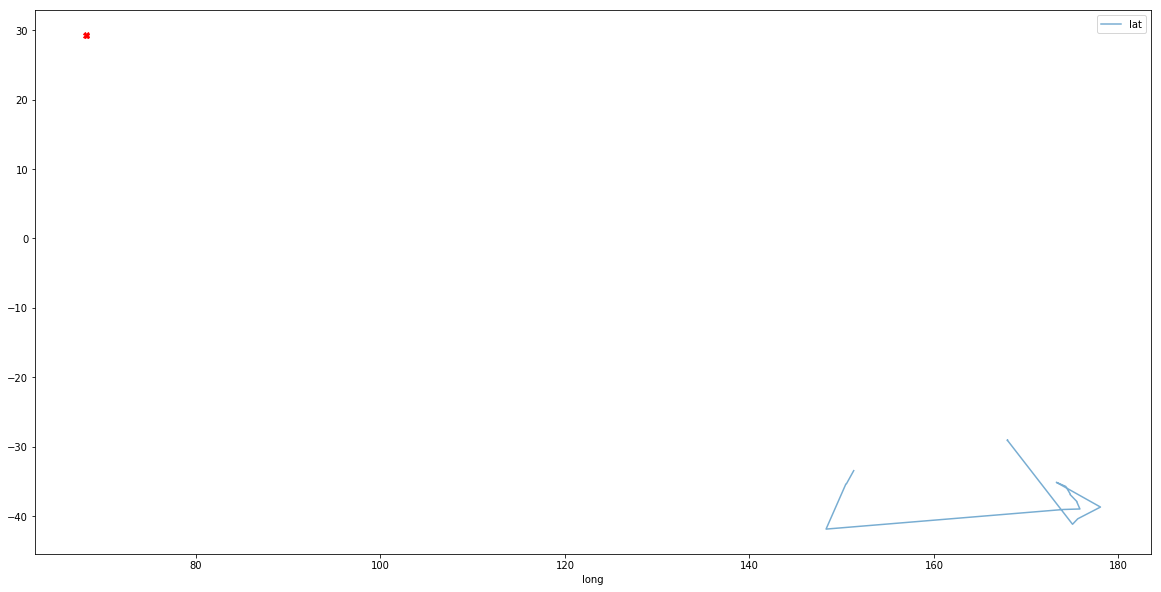

In [223]:
# Plot route
routex = df[['long','lat']].loc[taxis2[2]]
#routex

routex.plot(kind="line", x="long", y="lat", alpha=0.6, figsize=(20,10))
# Red X home / Korvatunturi
plt.plot(home[1], home[0], 'rX', label='point')
plt.show()

In [ ]:
# Plot route
routex = df[['long','lat']].loc[taxis2[4]]
#routex

routex.plot(kind="line", x="long", y="lat", alpha=0.6, figsize=(20,10))
# Red X home / Korvatunturi
plt.plot(home[1], home[0], 'rX', label='point')
plt.show()

In [ ]:
# as long as unassigned gifts remain
- pick furthest away
  as long as space:
# find n nearest
- if fit, add closest
# find nearest for all these
- add closest to this group # this is same as growing cluster with unit closest to any old item

# keep a alist of unassigned? or use sleigh==-1?
# how to keep indexing?


# when done, can still arrange each sleighs locations internally to shortest path
